In [139]:
# encoding: utf-8
# Author: Zhuangwei Kang

import os, sys
import matplotlib.pyplot as plt
from matplotlib import style
sys.path.append('../../')
from datapsr import *
import numpy as np
style.use(['classic'])
plt.rc('axes', axisbelow=True)
dpi=600

/Users/zhuangweikang/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


[0.27777778 0.1704918  0.24617347 0.09071274 0.03628602]
[0.19444444 0.0557377  0.19770408 0.0161987  0.00320171]
[0.20833333 0.03278689 0.13647959 0.0075594  0.00320171]
[0.33333333 0.24590164 0.27933673 0.13390929 0.03735326]


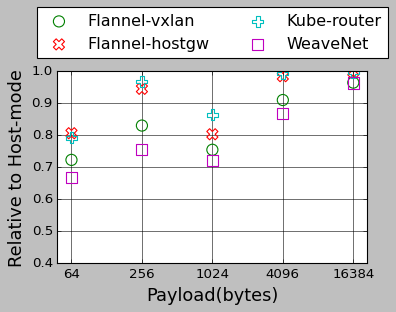

In [140]:
udp_plugins = ['hostnetwork-udp', 'flannel-vxlan-udp', 'flannel-hostgw-udp', 'kube-router-udp', 'weavenet-udp']
tcp_plugins = ['hostnetwork-tcp', 'flannel-vxlan-tcp', 'flannel-hostgw-tcp', 'kube-router-tcp', 'weavenet-tcp']
data_len = [64, 256, 1024, 4096, 16384]
udp_reliable_perf, _ = load_data(np.arange(len(data_len)), udp_plugins)
tcp_besteffort_perf, _ = load_data(np.arange(24, 29), tcp_plugins)
plt.figure(figsize=(5,3))
x = np.arange(len(data_len))
xticks=['64B', '256B', '1K', '4K', '16K']
plt.xticks(range(len(data_len)), xticks)
# plt.ylim(0, 100)
labels = ['Host-mode', 'Flannel-vxlan', 'Flannel-hostgw', 'Kube-router', 'WeaveNet']
# for i, cni in enumerate(udp_plugins):
#     throughput = udp_reliable_perf[udp_reliable_perf['cni'] == cni]['mbps(ave)']
#     plt.scatter(x, throughput, label='-'.join(cni.split('-')[:-1]).upper()+'-UDP', marker='o', color='C%i' % i)
markers = ['^', 'o', 'X', 'P', 's']
plt.ylim(0.4, 1.0)
x = np.arange(len(data_len))
plt.xticks(x, data_len)
total_width, n = 0.8, len(udp_plugins)-1
width = total_width / n
# x = x - (total_width - width) / 2
baseline = tcp_besteffort_perf[tcp_besteffort_perf['cni'] == 'hostnetwork-tcp']['mbps(ave)'].to_numpy()
for i, cni in enumerate(tcp_plugins):
    if i == 0:
        continue
    throughput = tcp_besteffort_perf[tcp_besteffort_perf['cni'] == cni]['mbps(ave)'].to_numpy()
#     plt.bar(x+(i-1)*width, throughput, label='-'.join(cni.split('-')[:-1]).upper(), width=width)
    plt.scatter(x, throughput/baseline, label=labels[i], marker=markers[i], c='',edgecolors='C%d'%(i), s=100)
    print(1-throughput/baseline)
    # plt.plot(x, throughput, label='-'.join(cni.split('-')[:-1]).upper()+'-TCP', marker='^', color='C%i' % i)

# plt.yticks(np.arange(4,12,2)/10)
plt.legend(bbox_to_anchor=(0.5, 1.2), ncol=2, loc='center', scatterpoints = 1)
plt.xlabel('Payload(bytes)', fontsize=16)
plt.ylabel('Relative to Host-mode', fontsize=16)
plt.grid(linestyle='-')
plt.savefig('throughput.png', dpi=dpi, bbox_inches='tight')


[1.6774193548387097, 2.024, 1.2389937106918238, 0.9871043376318875, 0.9944933920704846]
[1.45, 1.7888198757763973, 1.0277777777777777, 0.9816810344827586, 0.997863247863248]
[1.3902439024390245, 1.8322981366459625, 1.1044045676998369, 0.9903017241379312, 0.997863247863248]
[1.7777777777777777, 2.110091743119266, 1.3780487804878048, 1.0190597204574332, 0.9922992299229922]


/Users/zhuangweikang/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  app.launch_new_instance()


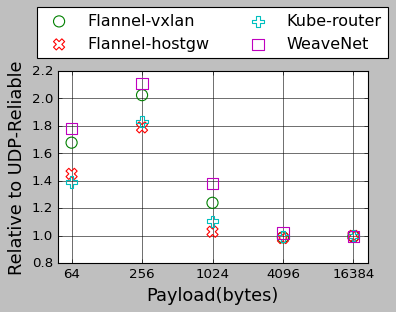

In [141]:
plt.figure(figsize=(5,3))
x = np.arange(len(data_len))
plt.xticks(x, data_len)
total_width, n = 0.8, len(udp_plugins)
width = total_width / n
# x = x - (total_width - width) / 2
# plt.ylim(0.5, 2.5)
for i in range(len(udp_plugins)):
    if i == 0:
        continue
    udp_throughput = udp_reliable_perf[udp_reliable_perf['cni'] == udp_plugins[i]]['mbps(ave)']
    tcp_throughput = tcp_besteffort_perf[tcp_besteffort_perf['cni'] == tcp_plugins[i]]['mbps(ave)']
    difference = tcp_throughput/udp_throughput
    print(difference.to_list())
#     plt.bar(x+i*width, difference, label=labels[i], width=width)
    plt.scatter(x, difference, label=labels[i], marker=markers[i], c='',edgecolors='C%d'%(i), s=100)

plt.legend(bbox_to_anchor=(0.5, 1.2), ncol=2, loc='center', scatterpoints = 1)
# plt.legend()
plt.xlabel('Payload(bytes)', fontsize=16)
plt.ylabel('Relative to UDP-Reliable', fontsize=16)
plt.grid(linestyle='-')
plt.savefig('tcp_vs_udp_throughput.png', dpi=dpi, bbox_inches='tight')

Description:  Reliability can be implemented at the transport layer or application layer in DDS, corresponding to TCP/TLS and DDS Reliability QoS policy, respectively. Since TCP itself guarantees reliable transmission, we can configure the DDS QoS policy as "BestEffort" to avoid redundant delivery acknowledgment at the application level. In contrast, UDP needs to coordinate with the "Reliable" QoS to ensure messages are transmitted reliably. Our previous experiment has shown the DDS performance with the UDP+Reliable configuration under various CNIs, while this experiment intends to expose that under the TCP+BestEffort knob setting. Therefore, we eventually aim at identifying the optimal configuration and K8s network plugin for reliable communication in DDS.

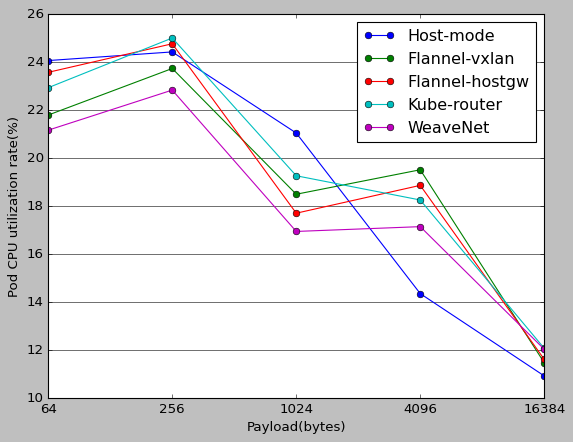

In [142]:
# _, perf = load_data(np.arange(24, 30), tcp_plugins)
plt.xticks(range(len(data_len)), data_len)
for i, cni in enumerate(tcp_plugins):
    cpu = tcp_besteffort_perf[tcp_besteffort_perf['cni'] == cni]['cpu']
    plt.plot(np.arange(len(data_len)), cpu, label=labels[i], marker='o')
# plt.ylim(0, 100)
plt.legend()
plt.xlabel('Payload(bytes)')
plt.ylabel('Pod CPU utilization rate(%)')
plt.grid(axis='y', linestyle='-')
plt.show()

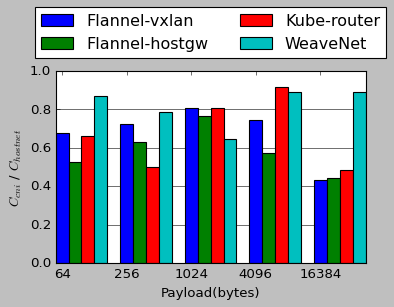

In [143]:
plt.figure(figsize=(5,3))
plt.xticks(range(len(data_len)), data_len)
pub_host_cpu = {}
sub_host_cpu = {}
x = np.arange(len(data_len))
# markers = ['o', '^', 'd', 'P']

baselines = []
for j, cni in enumerate(udp_plugins):
    pub_cpu = []
    pub_cpu_std = []
    sub_cpu = []
    sub_cpu_std = []
    for i in np.arange(5):
        data = pd.read_csv('throughputTest/%s/test-%d/metrics.csv' % (cni, i))
#         print(data)
        pub_cpu.append(data[data['name'] == 'raspberrypi87']['cpu%(avg)'])
        sub_cpu.append(data[data['name'] == 'raspberrypi89']['cpu%(avg)'])
        pub_cpu_std.append(data[data['name'] == 'raspberrypi87']['cpu%(std)'])
        sub_cpu_std.append(data[data['name'] == 'raspberrypi89']['cpu%(std)'])
    baselines.append(np.array(pub_cpu))
        
x = np.arange(len(data_len))
plt.xticks(x, data_len)
total_width, n = 0.8, len(udp_plugins)-1
width = total_width / n
# x = x - (total_width - width) / 2
for j, cni in enumerate(tcp_plugins):
    pub_cpu = []
    pub_cpu_std = []
    sub_cpu = []
    sub_cpu_std = []
    for i in np.arange(24, 29):
        data = pd.read_csv('throughputTest/%s/test-%d/metrics.csv' % (cni, i))
        pub_cpu.append(data[data['name'] == 'raspberrypi87']['cpu%(avg)'])
        sub_cpu.append(data[data['name'] == 'raspberrypi89']['cpu%(avg)'])
        pub_cpu_std.append(data[data['name'] == 'raspberrypi87']['cpu%(std)'])
        sub_cpu_std.append(data[data['name'] == 'raspberrypi89']['cpu%(std)'])
    if j == 0:
#         baseline = np.array(pub_cpu)
        continue
    
    plt.bar(x+(j-1)*width, np.reshape(np.array(pub_cpu)/baselines[j], len(x)), width=width, color='C%d' % (j-1), label=labels[j])
#     plt.fill_between(x, np.reshape(np.array(pub_cpu)-np.array(pub_cpu_std), len(x)), np.reshape(np.array(pub_cpu)+np.array(pub_cpu_std), len(x)), alpha=.2, color='C%d' % (j))

# plt.ylim(0.5, 2.5)
plt.legend(bbox_to_anchor=(0.5, 1.2), ncol=2, loc='center')
plt.xlabel('Payload(bytes)')
plt.ylabel('$C_{cni}$ / $C_{hostnet}$')
plt.grid(axis='y', linestyle='-')
plt.savefig('cpu.png', dpi=dpi, bbox_inches='tight')

/Users/zhuangweikang/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


[0.44702467 0.4058745  0.27046632 0.29429658 0.16666667]
[0.21770682 0.20293725 0.12642487 0.14372624 0.04197839]
[0.22060958 0.20293725 0.13264249 0.15893536 0.04613466]
[0.4862119  0.47263017 0.30777202 0.30038023 0.19201995]


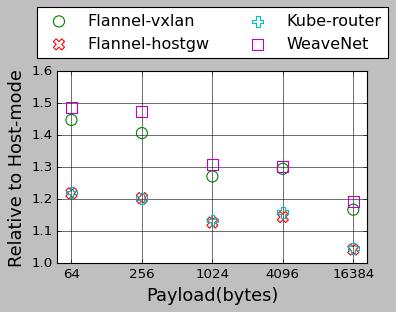

In [144]:
plt.figure(figsize=(5,3))
x = np.arange(len(data_len))
plt.xticks(x, data_len)
total_width, n = 0.8, len(udp_plugins)-1
width = total_width / n
# x = x - (total_width - width) / 2

_, udp_reliable_perf = load_data(np.arange(len(data_len)), udp_plugins, latencyTest=True)
_, tcp_besteffort_perf = load_data(np.arange(24, 29), tcp_plugins, latencyTest=True)

baseline = tcp_besteffort_perf[tcp_besteffort_perf['cni'] == 'hostnetwork-tcp']['90%'].to_numpy()
for i, cni in enumerate(tcp_plugins):
    if i == 0:
        continue
    lat = tcp_besteffort_perf[tcp_besteffort_perf['cni'] == cni]['90%'].to_numpy()
    lat_err = tcp_besteffort_perf[tcp_besteffort_perf['cni'] == cni]['std'].to_numpy()
    plt.scatter(x, lat/baseline, label=labels[i], marker=markers[i], c='',edgecolors='C%d'%(i), s=100)
    print(lat/baseline - 1)
#     plt.bar(x+(i-1)*width, lat/baseline, width=width, label=labels[i])
    # plt.bar(x+i*width, lat, yerr=lat_err, width=width, label='-'.join(cni.split('-')[:-1]).upper()+'-TCP', capsize=3)

# plt.ylim(1.0, 1.5)
plt.legend(bbox_to_anchor=(0.5, 1.2), ncol=2, loc='center', scatterpoints = 1)
plt.xlabel('Payload(bytes)', fontsize=16)
plt.ylabel('Relative to Host-mode', fontsize=16)
plt.grid(linestyle='-')
plt.savefig('latency.png', dpi=dpi, bbox_inches='tight')

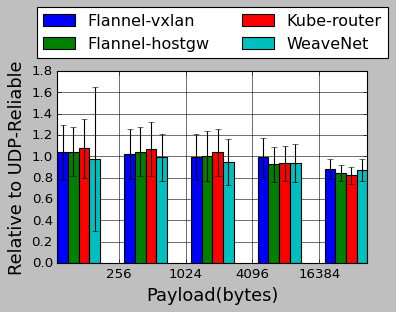

In [145]:
plt.figure(figsize=(5,3))
x = np.arange(len(data_len))
plt.xticks(x, data_len)
total_width, n = 0.8, len(udp_plugins)
width = total_width / n
# x = x - (total_width - width) /2

_, udp_reliable_perf = load_data(np.arange(len(data_len)), udp_plugins, latencyTest=True)
_, tcp_besteffort_perf = load_data(np.arange(24, 29), tcp_plugins, latencyTest=True)

for i in range(len(tcp_plugins)):
    if i == 0:
        continue
    tcp_lat = tcp_besteffort_perf[tcp_besteffort_perf['cni'] == tcp_plugins[i]]['90%']
    udp_lat = udp_reliable_perf[udp_reliable_perf['cni'] == udp_plugins[i]]['90%']
    tcp_lat_std = tcp_besteffort_perf[tcp_besteffort_perf['cni'] == tcp_plugins[i]]['std']
    diff = tcp_lat/udp_lat
    diff_std = tcp_lat_std / udp_lat
    plt.bar(x+i*width, diff, width=width, label=labels[i], yerr=diff_std, capsize=3)
#     plt.scatter(x, diff, label=labels[i], marker=markers[i], c='',edgecolors='C%d'%(i), s=100)

# plt.ylim(0.6, 1.8)
# plt.yticks(np.arange(6,13,2)/10)
plt.legend(bbox_to_anchor=(0.5, 1.2), ncol=2, loc='center', scatterpoints = 1)
plt.xlabel('Payload(bytes)', fontsize=16)
plt.ylabel('Relative to UDP-Reliable', fontsize=16)
plt.grid(linestyle='-')
plt.savefig('tcp_vs_udp_latency.png', dpi=dpi, bbox_inches='tight')